# Sprawozdanie z Laboratorium 6
## Autorzy: Mateusz Pawliczek, Piotr Świerzy  
## Data: 06.05.2025

W zadaniu 1 obliczamy wartość całki funkcji  w przedziale  za pomocą dwóch metod numerycznych: kwadratury adaptacyjnej trapezów oraz kwadratury adaptacyjnej Gaussa-Kronroda. Celem zadania jest porównanie efektywności tych dwóch metod w zależności od zadanej tolerancji błędu oraz liczby ewaluacji funkcji.

Obie metody mają być również zestawione z metodami wykorzystanymi do obliczenia całki w poprzednim laboratorium. Były to metody `Kwadratów`, `Trapezów`, `Simpsona` oraz `Gaussa Legendre'a`.

W realizacji została wykorzystana funkcja:

```math
\int_0^1 \frac{4}{1 + x^2} \, dx
```

Została ona zaimplementowana w następujący sposób:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

def f(x):
    return 4 / (1 + x**2)

## 1. Kwadratura adaptacyjna Gaussa-Kronroda

Do realizacji zadania zaimplementowano funkcję obliczającą całkę metodą Gaussa-Kronroda, która korzysta z funkcji `scipy.integrate.quad_vec`. Metoda ta jest bardziej zaawansowaną wersją kwadratury Gaussa i pozwala na obliczenie całki z większą dokładnością przy mniejszej liczbie punktów. Implementacja ta polega na wywołaniu wbudowanej funkcji, która automatycznie dostosowuje liczbę punktów do zadanej tolerancji błędu.

In [2]:
def gauss_kronrod(f, a, b, tolerance):
    result, error, info = integrate.quad_vec(f, a, b, epsabs=tolerance, full_output=1)
    return result, info.neval

Funkcja `gauss_kronrod` oblicza wartość całki z funkcji f(x) na przedziale  przy zadanej tolerancji `tolerance`. Zwraca zarówno wynik obliczeń, jak i liczbę ewaluacji funkcji.

## 2. Kwadratura adaptacyjna trapezów

W celu obliczenia całki metodą trapezów zaimplementowano funkcję adaptacyjną, która rekurencyjnie dzieli przedziały, aż do osiągnięcia zadanej tolerancji błędu. Na początku obliczamy przybliżenie całki na dużym przedziale, a następnie dzielimy go na mniejsze przedziały i powtarzamy proces aż do uzyskania odpowiedniej dokładności.

In [3]:
def adaptive_trapezoid(f, a, b, tolerance, max_depth = 20):
    count = [0]
    
    def recursive(f, a, b, fa, fb, prev, tolerance, depth):
        mid = (a+b) / 2
        fm = f(mid)
        count[0] += 1
        left = (fa + fm) * (mid - a) / 2
        right = (fm + fb) * (b - mid) / 2
        if abs(prev - (left + right)) < tolerance or depth >= max_depth:
            return left + right
        else:
            return recursive(f, a, mid, fa, fm, left, tolerance / 2, depth + 1) +\
                   recursive(f, mid, b, fm, fb, right, tolerance / 2, depth + 1)

    fa, fb = f(a), f(b)
    count[0] += 2
    initial = (fa + fb) * (b - a) / 2
    result = recursive(f, a, b, fa, fb, initial, tolerance, 0)
    return result, count[0]

Funkcja `adaptive_trapezoid` implementuje kwadraturę adaptacyjną trapezów, dzieląc przedziały rekurencyjnie w zależności od zadanej tolerancji błędu. Zwraca wynik obliczeń oraz liczbę ewaluacji funkcji.

## 3. Obliczanie błędu względnego

Do porównania metod numerycznych obliczany jest błąd względny w stosunku do prawdziwej wartości całki, którą jest . Funkcja `relative_error` oblicza błąd dla uzyskanego wyniku.

In [4]:
true_value = np.pi

def relative_error(x):
    return abs((x - true_value) / true_value)

Funkcja `relative_error` zwraca wartość błędu względnego dla obliczonej wartości , porównując ją z prawdziwą wartością .

## 4. Przeprowadzenie obliczeń dla różnych tolerancji

Do analizy zastosowano różne wartości tolerancji błędu, aby porównać efektywność obu metod. Dla każdej z tolerancji obliczane są zarówno błędy względne, jak i liczba ewaluacji funkcji. Tolerancje zostały zadane w zakresie od 0 do 10^(-14).

Dodatkowo w tym razem z oboma wyżej wymienionymi metodami zostały porównane metody z poprzedniego laboratorium czyli metody `Prostokątów`, `Trapezów`, `Simpsona` i `Gaussa Legendre'a`.

In [5]:
def midpoint_rectangular_formula(a, b, m):
    step = (b - a) / m
    result = 0
    for i in range(m):
        midpoint = a + (i + 0.5) * step
        result += f(midpoint)
    return result * step

def trapezoidal_formula(a, b, m):
    x = np.linspace(a, b, m)
    y = f(x)
    return integrate.trapezoid(y , x)

def simpsons_formula(a, b, m):
    # only works for odd number of points
    if m % 2 == 0:
        m += 1
    x = np.linspace(a, b, m)
    y = f(x)
    return integrate.simpson(y , x = x)

## 5. Wizualizacja wyników

Na końcu, aby zobrazować efektywność wybranych metod, porównujemy błędy względne w zależności od liczby ewaluacji funkcji na wykresie. Wartości błędów są przedstawione w skali logarytmicznej.

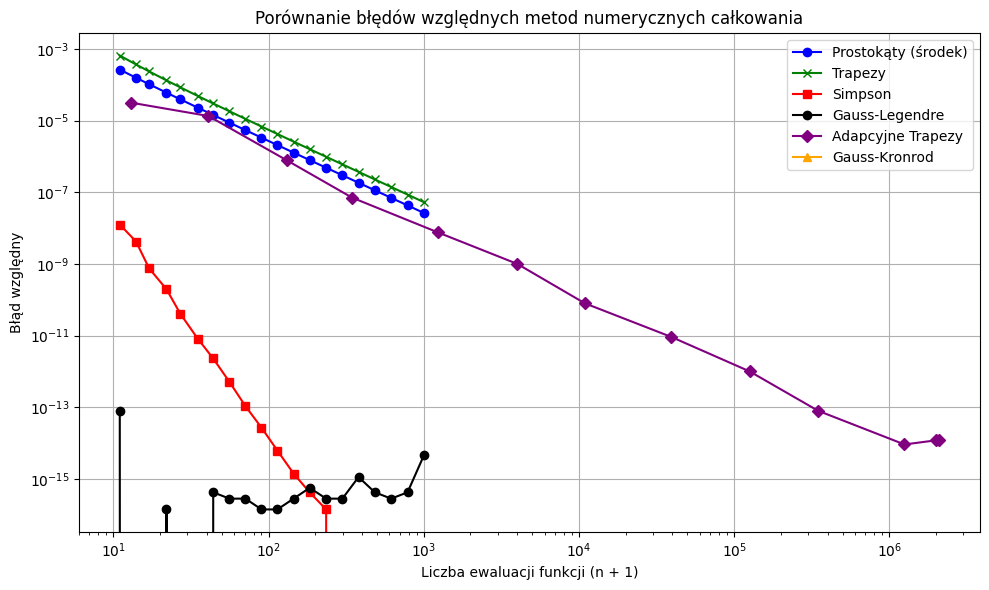

In [6]:
h_values = np.logspace(-1, -3, 20)
n_values = np.round(1 / h_values).astype(int)

mid_errors = [relative_error(midpoint_rectangular_formula(0, 1, n)) for n in n_values]
trap_errors = [relative_error(trapezoidal_formula(0, 1, n)) for n in n_values]
simp_errors = [relative_error(simpsons_formula(0, 1, n)) for n in n_values]

def f_trans(x):
    return f(x/2 + 1/2)

gauss_errors = []

for n in n_values:
    x, w = np.polynomial.legendre.leggauss(n)
    approx = np.sum(f_trans(x) * w) / 2
    gauss_errors.append(relative_error(approx))

tolerances = np.logspace(-2, -14, 13)

trap_errs = []
trap_evals = []
gk_errs = []
gk_evals = []

for tol in tolerances:
    result, evals = adaptive_trapezoid(f, 0, 1, tol)
    trap_errs.append(relative_error(result))
    trap_evals.append(evals)

    result, evals = gauss_kronrod(f, 0, 1, tol)
    gk_errs.append(relative_error(result))
    gk_evals.append(evals)


plt.figure(figsize=(10, 6))
plt.plot(n_values + 1, mid_errors, label='Prostokąty (środek)', color='blue', marker='o')
plt.plot(n_values + 1, trap_errors, label='Trapezy', color='green', marker='x')
plt.plot(n_values + 1, simp_errors, label='Simpson', color='red', marker='s')
plt.plot(n_values + 1, gauss_errors, label='Gauss-Legendre', color='black',  marker='o', linestyle='-')

plt.plot(trap_evals, trap_errs, label='Adapcyjne Trapezy', color='purple', marker='D')

plt.plot(gk_evals, gk_errs, label='Gauss-Kronrod', color='orange', marker='^')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Liczba ewaluacji funkcji (n + 1)')
plt.ylabel('Błąd względny')
plt.title('Porównanie błędów względnych metod numerycznych całkowania')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 6. Wnioski

Na podstawie przeprowadzonych obliczeń i analizy błędów względnych dla różnych metod numerycznych, możemy sformułować następujące wnioski:

- Kwadratura adaptacyjna trapezów okazała się mieć wyniki bardzo zbliżone do metod prostokątów (środek) oraz trapezów. Choć adaptacyjna metoda trapezów wypadła lekko lepiej od tych dwóch metod, różnice były minimalne. Niemniej jednak, w porównaniu do metod prostokątnych i trapezowych, adaptacyjna metoda wymagała większej liczby ewaluacji funkcji, szczególnie przy mniejszych tolerancjach.

- Kwadratura Gaussa-Kronroda wykazała się zdecydowanie najlepszymi wynikami. Błąd względny w tej metodzie był praktycznie zerowy w porównaniu do pozostałych metod, co świadczy o jej bardzo wysokiej dokładności. Dodatkowo, liczba ewaluacji funkcji była znacznie mniejsza w porównaniu do metod adaptacyjnych, co czyni ją najefektywniejszą metodą w kontekście zarówno dokładności, jak i liczby obliczeń.

Podsumowując, metoda Gaussa-Kronroda okazała się być najbardziej efektywna w obliczaniu całek, dając najdokładniejsze wyniki przy minimalnej liczbie ewaluacji funkcji. Metoda adaptacyjna trapezów natomiast, mimo że wykazała się nieco lepszymi wynikami niż tradycyjne metody prostokątów i trapezów, wciąż nie dorównywała metodzie Gaussa-Kronroda pod względem precyzji.

## Zadanie 2 Pdpkt a) oraz b)

Zadanie drugie skupiało się na przeprowadzeniu identycznego działania i jedynie podmiany funkcji na inną.

### Zadanie a)

Funkcja dla której wyznaczono całkę ma następujący wzór:

```math
\int_0^1 \sqrt{x} \log{x} \, dx = -\frac{4}{9}
```

Została ona zaimplementowana w następujący sposób:

In [7]:
def f(x):
    return np.sqrt(x) * np.log(x)

true_value = -4/9

Dla tej funkcji przerowadzono identyczne działania jak w zadaniu 1, wyniki przedstawiono na wykresie.\
Ze względu na dziedzinę funkcji f, dolną granicę całkowania zaczynamy od $10^{-16}$ zamiast $0$.

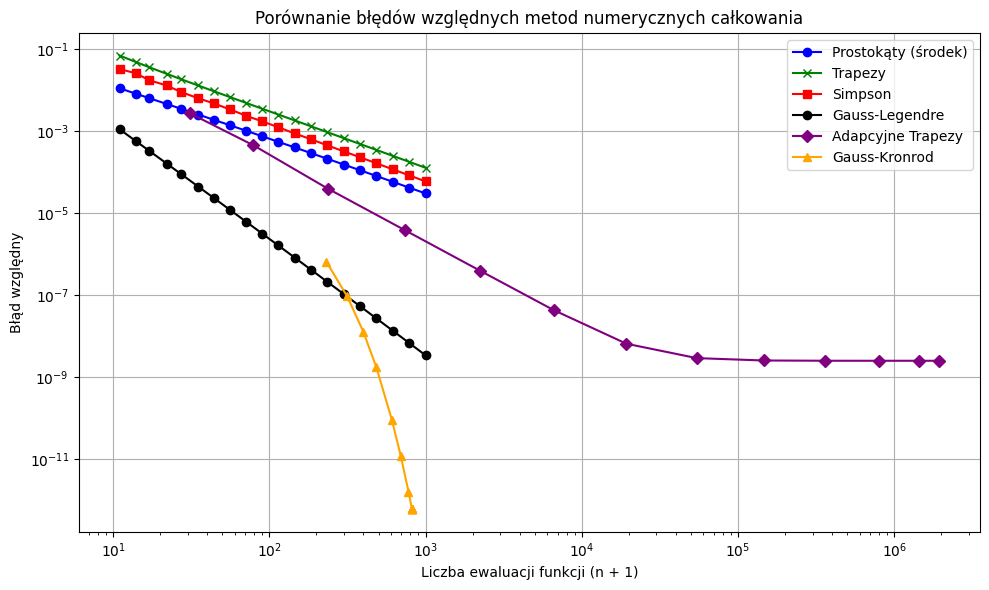

In [8]:
h_values = np.logspace(-1, -3, 20)
n_values = np.round(1 / h_values).astype(int)

mid_errors = [relative_error(midpoint_rectangular_formula(1e-16, 1, n)) for n in n_values]
trap_errors = [relative_error(trapezoidal_formula(1e-16, 1, n)) for n in n_values]
simp_errors = [relative_error(simpsons_formula(1e-16, 1, n)) for n in n_values]
gauss_errors = []

for n in n_values:
    x, w = np.polynomial.legendre.leggauss(n)
    approx = np.sum(f_trans(x) * w) / 2
    gauss_errors.append(relative_error(approx))

tolerances = np.logspace(-2, -14, 13)

trap_errs = []
trap_evals = []
gk_errs = []
gk_evals = []

for tol in tolerances:
    result, evals = adaptive_trapezoid(f, 1e-16, 1, tol)
    trap_errs.append(relative_error(result))
    trap_evals.append(evals)

    result, evals = gauss_kronrod(f, 1e-16, 1, tol)
    gk_errs.append(relative_error(result))
    gk_evals.append(evals)


plt.figure(figsize=(10, 6))
plt.plot(n_values + 1, mid_errors, label='Prostokąty (środek)', color='blue', marker='o')
plt.plot(n_values + 1, trap_errors, label='Trapezy', color='green', marker='x')
plt.plot(n_values + 1, simp_errors, label='Simpson', color='red', marker='s')
plt.plot(n_values + 1, gauss_errors, label='Gauss-Legendre', color='black',  marker='o', linestyle='-')

plt.plot(trap_evals, trap_errs, label='Adapcyjne Trapezy', color='purple', marker='D')

plt.plot(gk_evals, gk_errs, label='Gauss-Kronrod', color='orange', marker='^')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Liczba ewaluacji funkcji (n + 1)')
plt.ylabel('Błąd względny')
plt.title('Porównanie błędów względnych metod numerycznych całkowania')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Wnioski a)

W podpunkcie a) metoda Gaussa-Kronroda ponownie osiągnęła najniższy błąd względny spośród wszystkich metod, chociaż w pewnym zakresie dokładności chwilowo ustępowała metodzie Gaussa-Legendre’a.

Metoda adaptacyjna trapezów okazała się dokładniejsza niż klasyczne metody prostokątów i trapezów, co świadczy o jej większej elastyczności w dopasowywaniu się do charakteru funkcji podcałkowej.

Jednak w porównaniu do metod nieadaptacyjnych, adaptacyjna trapezowa zaczęła wymagać znacznie większej liczby ewaluacji funkcji, co stanowi istotny koszt obliczeniowy przy wyższych dokładnościach.

### Zadaie b)

Zadanie analogiczne do podpunktu a) ale tym razem funkcja po której całkujemy to:

```math
\int_0^1 \frac{1}{(x - x_0)^2 + a} \, dx
```

```math
= \frac{1}{\sqrt{a}} \left( \arctan\left( \frac{1 - x_0}{\sqrt{a}} \right) + \arctan\left( \frac{x_0}{\sqrt{a}} \right) \right)
```

Jej implementacja wygląda następująco:

In [9]:
def f(x, a = 0.001, b = 0.004):
    return (1/((x-0.3)**2 + a) + 1/((x-0.9)**2 + b) - 6)

a = 0.001
b = 0.004
true_value = ((np.arctan((1-0.3)/np.sqrt(a)) + np.arctan(0.3/np.sqrt(a))))/np.sqrt(a) +\
             ((np.arctan((1-0.9)/np.sqrt(b)) + np.arctan(0.9/np.sqrt(b))))/np.sqrt(b) - 6

Przeprowadzamy identyczne działania co w zadaniu nr 1:

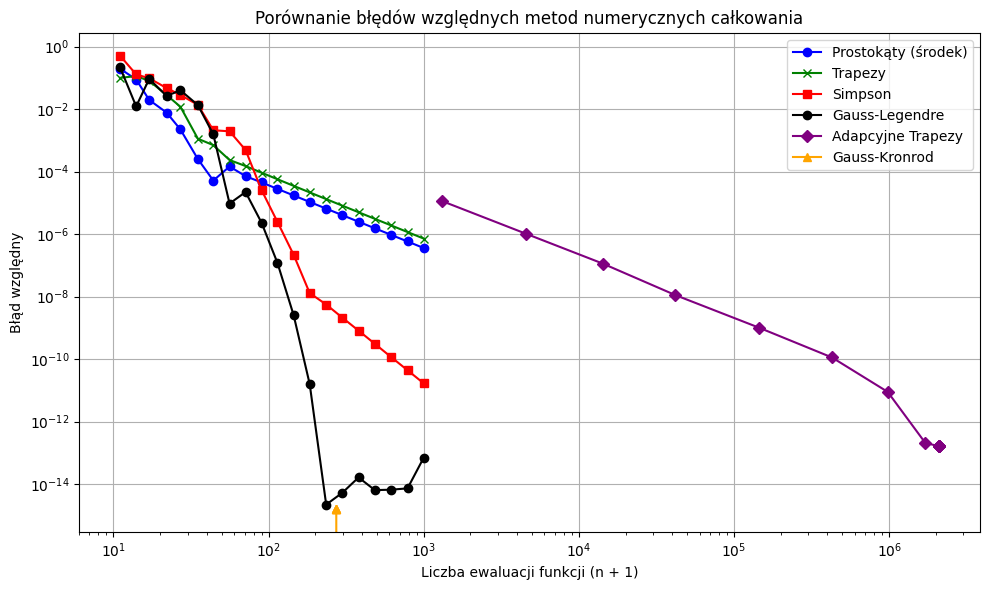

In [10]:
h_values = np.logspace(-1, -3, 20)
n_values = np.round(1 / h_values).astype(int)

mid_errors = [relative_error(midpoint_rectangular_formula(0, 1, n)) for n in n_values]
trap_errors = [relative_error(trapezoidal_formula(0, 1, n)) for n in n_values]
simp_errors = [relative_error(simpsons_formula(0, 1, n)) for n in n_values]

gauss_errors = []

for n in n_values:
    x, w = np.polynomial.legendre.leggauss(n)
    approx = np.sum(f_trans(x) * w) / 2
    gauss_errors.append(relative_error(approx))

tolerances = np.logspace(-2, -14, 13)

trap_errs = []
trap_evals = []
gk_errs = []
gk_evals = []

for tol in tolerances:
    result, evals = adaptive_trapezoid(f, 0, 1, tol)
    trap_errs.append(relative_error(result))
    trap_evals.append(evals)

    result, evals = gauss_kronrod(f, 0, 1, tol)
    gk_errs.append(relative_error(result))
    gk_evals.append(evals)


plt.figure(figsize=(10, 6))
plt.plot(n_values + 1, mid_errors, label='Prostokąty (środek)', color='blue', marker='o')
plt.plot(n_values + 1, trap_errors, label='Trapezy', color='green', marker='x')
plt.plot(n_values + 1, simp_errors, label='Simpson', color='red', marker='s')
plt.plot(n_values + 1, gauss_errors, label='Gauss-Legendre', color='black',  marker='o', linestyle='-')

plt.plot(trap_evals, trap_errs, label='Adapcyjne Trapezy', color='purple', marker='D')

plt.plot(gk_evals, gk_errs, label='Gauss-Kronrod', color='orange', marker='^')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Liczba ewaluacji funkcji (n + 1)')
plt.ylabel('Błąd względny')
plt.title('Porównanie błędów względnych metod numerycznych całkowania')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Wniosek

Wnioski z tego przykładu są zbieżne z wcześniejszymi analizami — metoda Gaussa-Kronroda ponownie uzyskała najmniejszy błąd względny spośród wszystkich badanych metod.

Metoda adaptacyjnych trapezów osiągnęła nieco lepszą dokładność niż metody prostokątów i trapezów, co potwierdza zalety adaptacyjnego podejścia. Jednak poprawa dokładności została okupiona znacząco większą liczbą ewaluacji funkcji niż w przypadku pozostałych metod, co może ograniczać jej efektywność obliczeniową przy bardziej złożonych problemach.

## Wniosek Końcowy

Analiza wszystkich trzech przykładów pozwala na sformułowanie ogólnych wniosków dotyczących skuteczności badanych metod numerycznych całkowania. Metoda Gaussa-Kronroda we wszystkich przypadkach okazała się najdokładniejsza, osiągając najniższy błąd względny przy relatywnie niewielkiej liczbie ewaluacji funkcji podcałkowej. Jej efektywność i stabilność czyni ją najbardziej niezawodną spośród testowanych metod.

Metoda adaptacyjna trapezów konsekwentnie dawała lepsze wyniki niż klasyczne metody prostokątów i trapezów, szczególnie dla funkcji o bardziej złożonym przebiegu. Jednak zwiększona dokładność wiązała się z istotnie większą liczbą ewaluacji funkcji, co może być ograniczeniem w zastosowaniach wymagających dużej wydajności obliczeniowej.

Z kolei klasyczne metody prostokątów, trapezów i Simpsona, choć prostsze w implementacji i mniej kosztowne obliczeniowo, charakteryzowały się wyraźnie większym błędem i mniejszą elastycznością względem trudniejszych funkcji.

Podsumowując, dobór metody numerycznej powinien być świadomym kompromisem między dokładnością a kosztami obliczeniowymi, zależnym od rodzaju funkcji podcałkowej oraz wymagań konkretnego zastosowania.